In [30]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import rasterio
import torch
import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader

from estuary.model.data import EstuaryDataModule, EstuaryDataset, _load_labels
from estuary.model.module import EstuaryModule
from estuary.util import broad_band, false_color

In [2]:
module = EstuaryModule.load_from_checkpoint(
    "/Users/kyledorman/data/results/estuary/train/20250927-165412/checkpoints/last.ckpt",
    accelerator="cpu",
    workers=0,
    persistent_workers=False,
    batch_size=1,
    prefetch_factor=0,
    strict=False,
)
module = module.eval()

In [3]:
dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()

Some label classes will be ignored {'unsure'}


In [4]:
dl = dm.val_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

thresholds = np.linspace(0, 1, 101)  # e.g., 0.00, 0.01, ..., 1.00
scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0.0)
    rec = recall_score(y_true, y_pred)
    scores.append((t, f1, acc, prec, rec))

# put into DataFrame for analysis
df_scores = pd.DataFrame(scores, columns=["threshold", "f1", "accuracy", "precision", "recall"])

# best threshold by F1
best_f1_row = df_scores.loc[df_scores["f1"].idxmax()]
print(best_f1_row)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:17<00:00, 38.22it/s]


threshold    0.240000
f1           0.961644
accuracy     0.959004
precision    0.956403
recall       0.966942
Name: 24, dtype: float64


(array([305.,   8.,   6.,   5.,   1.,   5.,   6.,   7.,   9., 331.]),
 array([9.37368623e-06, 1.00008391e-01, 2.00007409e-01, 3.00006419e-01,
        4.00005430e-01, 5.00004470e-01, 6.00003481e-01, 7.00002491e-01,
        8.00001502e-01, 9.00000513e-01, 9.99999523e-01]),
 <BarContainer object of 10 artists>)

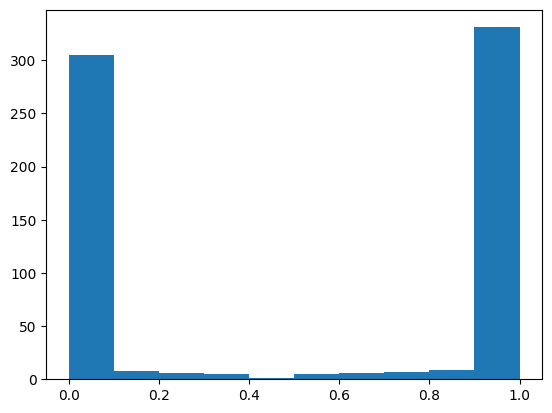

In [5]:
plt.hist(y_prob)

<Axes: xlabel='threshold', ylabel='f1'>

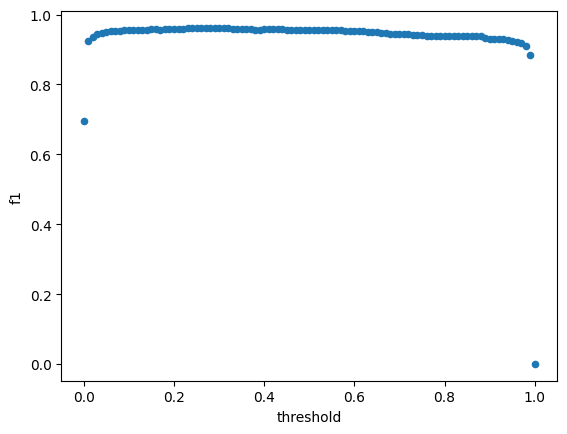

In [6]:
df_scores.plot.scatter(x="threshold", y="f1")

In [7]:
df_scores[df_scores.threshold == 0.5]

,threshold,f1,accuracy,precision,recall
50,0.5,0.957004,0.954612,0.963687,0.950413


In [8]:
results_df = []

In [9]:
dl = dm.val_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "val",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 683/683 [00:18<00:00, 37.55it/s]


0.9546120058565154

In [10]:
dl = dm.test_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "test",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 673/673 [00:19<00:00, 35.33it/s]


0.9049034175334324

In [11]:
int(Path(batch["source_tif"][i]).parents[2].name)

11

In [12]:
dl = dm.train_dataloader()

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = dm.val_aug(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        results_df.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[2].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5665/5665 [02:09<00:00, 43.62it/s]


0.9915269196822595

In [13]:
results_df = pd.DataFrame(results_df)
results_df["correct"] = results_df.y_true == results_df.y_pred

results_df.head(5)

,source_tif,y_true,y_prob,y_pred,region,dataset,correct
0,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000092,0,16,val,True
1,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000073,0,16,val,True
2,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000113,0,16,val,True
3,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000354,0,16,val,True
4,/Users/kyledorman/data/estuary/dataset/images/...,0,0.000083,0,16,val,True


In [14]:
results_df.region.unique()

array([  16,   21,   56,   51, 2145,   25,   77,   48,   15,   50,   72,
         18,   27,   11,   97,   86, 2163,   64,   61,   66,   58,   19,
         68,   40,   96,   39, 2162,   53,   67,   92,   12,   62, 2138,
         95,   37,   93,   46,   84,   79,   31,   59,   81,   83,   41,
         20,   35,   98,   17,   85, 2147,   29,   45,   33,   52,   87,
         32,   34,   28,   38,   54,   44,   26,   55,   88,   23,   57,
       2161,   22,   73,   70,   14,   63,   94,   43,   65])

In [15]:
# Group by region and compute accuracy
acc_by_region = results_df.groupby("region").correct.mean()
open_pct = results_df.groupby("region").y_true.mean()
dataset = results_df.groupby("region").dataset.first()

# Combine into a DataFrame for display
acc_df = pd.DataFrame(
    {
        "accuracy": acc_by_region,
        "open_pct": open_pct,
        "dataset": dataset,
    }
).reset_index()

# Show the result
region_stats = acc_df.set_index("region").sort_values(by="accuracy")

region_stats.head(5)

,accuracy,open_pct,dataset
region,,,
11,0.636364,0.909091,test
27,0.831461,0.404494,test
21,0.908163,0.846939,val
2145,0.920792,0.544554,val
58,0.921348,0.438202,train


In [16]:
region_stats[region_stats.accuracy < 0.8]

,accuracy,open_pct,dataset
region,,,
11,0.636364,0.909091,test


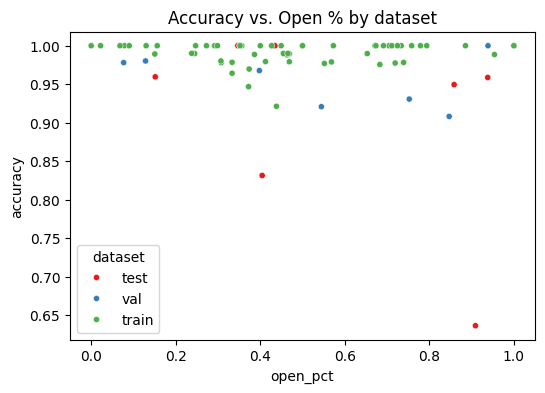

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# df has columns: accuracy, open_pct, dataset
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=region_stats,
    x="open_pct",
    y="accuracy",
    hue="dataset",  # color by dataset
    palette="Set1",  # you can pick another palette
    s=20,  # point size
)
plt.title("Accuracy vs. Open % by dataset")
plt.show()

In [20]:
N = 5
best_counts = region_stats.tail(N)
worse_counts = region_stats.head(N)

display(best_counts)
display(worse_counts)

,accuracy,open_pct,dataset
region,,,
67,1.0,0.673684,train
68,1.0,0.449438,train
70,1.0,0.426966,train
73,1.0,0.352273,train
2163,1.0,1.0,train


,accuracy,open_pct,dataset
region,,,
11,0.636364,0.909091,test
27,0.831461,0.404494,test
21,0.908163,0.846939,val
2145,0.920792,0.544554,val
58,0.921348,0.438202,train


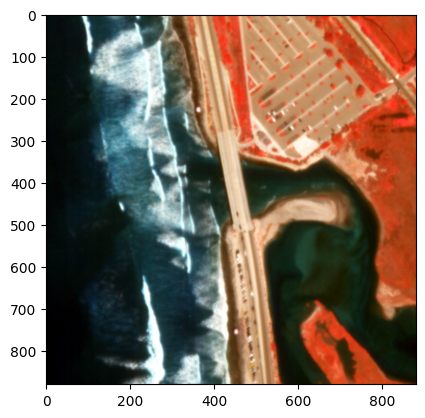

In [18]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/11/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
plt.imshow(img)

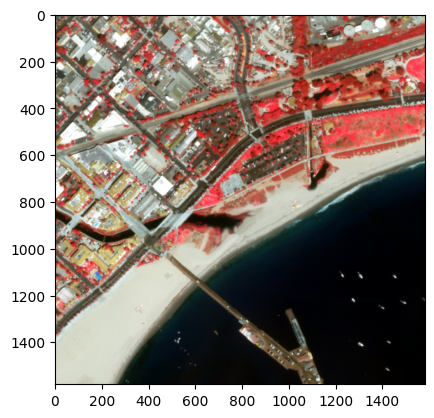

In [21]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/27/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
plt.imshow(img)

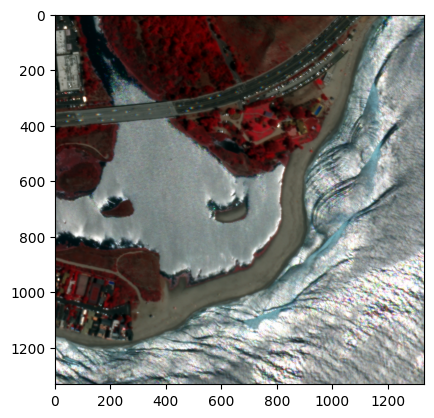

In [23]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/2145/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
plt.imshow(img)

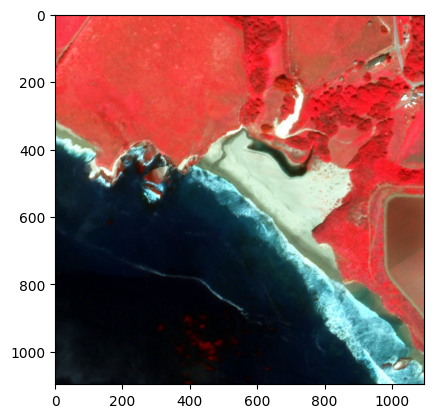

In [24]:
plt.figure()
pth = list(
    Path("/Volumes/x10pro/estuary/skysat/results/").glob("*/58/files/*pansharpened_clip.tif")
)[0]
with rasterio.open(pth) as src:
    data = src.read()
    nodata = src.read(1, masked=True).mask
    img = false_color(data, nodata)
plt.imshow(img)

In [26]:
region_stats[region_stats.dataset == "test"]

,accuracy,open_pct,dataset
region,,,
11,0.636364,0.909091,test
27,0.831461,0.404494,test
72,0.949495,0.858586,test
15,0.958763,0.938144,test
18,0.959596,0.151515,test
48,1.000000,0.434783,test
50,1.000000,0.346939,test


In [27]:
region_stats[region_stats.dataset == "val"]

,accuracy,open_pct,dataset
region,,,
21,0.908163,0.846939,val
2145,0.920792,0.544554,val
56,0.930693,0.752475,val
77,0.967742,0.397849,val
16,0.978022,0.076923,val
25,0.980198,0.128713,val
51,1.000000,0.938776,val


In [70]:
Path(batch["source_tif"][0]).parents[1].name

'2145'

In [71]:
ca_all_labels = _load_labels(
    module.conf.classes, "/Volumes/x10pro/estuary/ca_all/dove/labeling/labels.csv"
)
ca_results_list = []

ds = EstuaryDataset(
    df=ca_all_labels,
    conf=module.conf,
    train=False,
)
dl = DataLoader(
    ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

y_prob = []
y_true = []
for batch in tqdm.tqdm(dl, total=len(dl)):
    batch = ds.transforms(batch)
    for k in batch.keys():
        if isinstance(batch[k], list):
            continue
        batch[k] = batch[k].to(module.device)
    logits = module.forward(batch)
    probs_pos = torch.sigmoid(logits)
    y_prob.extend(probs_pos.detach().cpu().numpy()[:, 0])
    y_true.extend(batch["label"].detach().cpu().numpy().tolist())

    for i in range(len(probs_pos)):
        ca_results_list.append(
            {
                "source_tif": batch["source_tif"][i],
                "y_true": batch["label"][i].detach().cpu().numpy(),
                "y_prob": probs_pos[i].detach().cpu().numpy()[0],
                "y_pred": (probs_pos[i] > 0.5).to(torch.int32).detach().cpu().numpy()[0],
                "region": int(Path(batch["source_tif"][i]).parents[1].name),
                "dataset": "train",
            }
        )

accuracy_score(y_true, np.int32(np.array(y_prob) > 0.5))

Some label classes will be ignored {'unsure'}
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1342/1342 [00:22<00:00, 59.02it/s]


0.8837555886736215

In [72]:
ca_results_df = pd.DataFrame(ca_results_list)
ca_results_df = pd.merge(
    ca_results_df, ca_all_labels[["source_tif", "orig_label"]], on="source_tif", how="left"
)
ca_results_df["correct"] = ca_results_df.y_true == ca_results_df.y_pred
ca_results_df.head()

,source_tif,y_true,y_prob,y_pred,region,dataset,orig_label,correct
0,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.168257,0,2145,train,open,False
1,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.998182,1,2145,train,open,True
2,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.991805,1,2145,train,open,True
3,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.998801,1,2145,train,open,True
4,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999719,1,2145,train,open,True


In [54]:
ca_results_df.groupby("orig_label").correct.mean()

orig_label
closed          0.955128
open            0.861069
perched open    0.412698
Name: correct, dtype: float64

In [65]:
for _, row in tqdm.tqdm(
    ca_results_df[~ca_results_df.correct].iterrows(), total=(~ca_results_df.correct).sum()
):
    label = "_".join(row.orig_label.split(" "))
    with rasterio.open(row.source_tif) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        if len(data) == 4:
            img = false_color(data, nodata)
        else:
            img = broad_band(data, nodata)
        img = Image.fromarray(img)

    save_dir = Path("/Volumes/x10pro/estuary/ca_all/inspect/") / label
    save_dir.mkdir(exist_ok=True, parents=True)
    img.save(save_dir / f"{Path(row.source_tif).stem}.jpg")

156it [00:00, 166.72it/s]


In [66]:
row.source_tif

'/Volumes/x10pro/estuary/ca_all/superdove/results/2025/7/2145/files/20250723_185940_81_24db_3B_AnalyticMS_SR_8b_clip.tif'